<a href="https://colab.research.google.com/github/ipeirotis-org/datasets/blob/main/Restaurant_Inspections/DOH_Restaurant_Inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www1.nyc.gov/site/doh/business/food-operators/the-inspection-process.page

See https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf

In [1]:
!pip install -q google-cloud-secret-manager

from google.colab import auth
auth.authenticate_user()

from google.cloud import secretmanager

def access_secret_version(project_id, secret_id, version_id):
    """
    Access the payload of the given secret version and return it.

    Args:
        project_id (str): Google Cloud project ID.
        secret_id (str): ID of the secret to access.
        version_id (str): ID of the version to access.
    Returns:
        str: The secret version's payload, or None if
        the version does not exist.
    """
    client = secretmanager.SecretManagerServiceClient()
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"
    response = client.access_secret_version(request={"name": name})
    return response.payload.data.decode("UTF-8")


mysql_pass = access_secret_version("nyu-datasets", "MYSQL_PASSWORD", "latest")

## Download Latest Dataset

In [2]:
!curl 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD' -o restaurants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 97.5M    0 97.5M    0     0  5591k      0 --:--:--  0:00:17 --:--:-- 5655k


In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("restaurants.csv", dtype = 'object')

In [4]:
initial_size = len(df)
initial_size

230525

In [5]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE DESCRIPTION      object
INSPECTION DATE          object
ACTION                   object
VIOLATION CODE           object
VIOLATION DESCRIPTION    object
CRITICAL FLAG            object
SCORE                    object
GRADE                    object
GRADE DATE               object
RECORD DATE              object
INSPECTION TYPE          object
Latitude                 object
Longitude                object
Community Board          object
Council District         object
Census Tract             object
BIN                      object
BBL                      object
NTA                      object
Location Point1          object
dtype: object

In [7]:
# Adding underscores in all column names
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_').upper())
df.columns = cols

In [8]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE_DESCRIPTION      object
INSPECTION_DATE          object
ACTION                   object
VIOLATION_CODE           object
VIOLATION_DESCRIPTION    object
CRITICAL_FLAG            object
SCORE                    object
GRADE                    object
GRADE_DATE               object
RECORD_DATE              object
INSPECTION_TYPE          object
LATITUDE                 object
LONGITUDE                object
COMMUNITY_BOARD          object
COUNCIL_DISTRICT         object
CENSUS_TRACT             object
BIN                      object
BBL                      object
NTA                      object
LOCATION_POINT1          object
dtype: object

In [9]:
df.drop('LOCATION_POINT1', axis=1, inplace=True)

## Cleaning Individual Columns

In [10]:
df.CAMIS.isnull().sum()

0

In [11]:
df.DBA.isnull().sum()

641

In [12]:
# Checks that all CAMIS values correpond to a unique DBA value
# ie the same CAMIS always has the same DBA
max_cardinality = df[['DBA','CAMIS']].pivot_table(
    index='CAMIS',
    values='DBA',
    aggfunc=pd.Series.nunique
).DBA.max()

assert(max_cardinality==1)

### INSPECTION_TYPE

In [13]:
df.INSPECTION_TYPE.value_counts()

INSPECTION_TYPE
Cycle Inspection / Initial Inspection                          122828
Cycle Inspection / Re-inspection                                43153
Pre-permit (Operational) / Initial Inspection                   34690
Pre-permit (Operational) / Re-inspection                        10078
Administrative Miscellaneous / Initial Inspection                5843
Pre-permit (Non-operational) / Initial Inspection                3039
Pre-permit (Operational) / Compliance Inspection                 1686
Cycle Inspection / Reopening Inspection                          1408
Administrative Miscellaneous / Re-inspection                     1158
Cycle Inspection / Compliance Inspection                          979
Pre-permit (Operational) / Reopening Inspection                   757
Smoke-Free Air Act / Initial Inspection                           561
Trans Fat / Initial Inspection                                    415
Calorie Posting / Initial Inspection                              357
Inte

In [14]:
sum(df.INSPECTION_TYPE.isnull())

2346

In [15]:
# We create a column "TO_DELETE" to mark the entries that we are not interested in.
# We will perform first the inspection/analysis on all the attributes, and then delete the rows

# Drop all cases where inspection is NULL
df['TO_DELETE'] = df.INSPECTION_TYPE.isnull()

In [16]:
sum(df['TO_DELETE'])

2346

In [17]:
# Break INSPECTION_TYPE into two columns, and also delete some inspection types

# Create a new column that contains the results of the split on the '/'' character
lst = df.INSPECTION_TYPE.str.split(' / ').values.tolist()
lst = [ l if type(l)==type(list()) else ['',''] for l in lst ]
t = pd.DataFrame(lst)


In [18]:
t[0].value_counts()

0
Cycle Inspection                168416
Pre-permit (Operational)         47406
Administrative Miscellaneous      7183
Pre-permit (Non-operational)      3308
                                  2346
Smoke-Free Air Act                 624
Trans Fat                          488
Calorie Posting                    425
Inter-Agency Task Force            329
Name: count, dtype: int64

In [19]:
t[1].value_counts()

1
Initial Inspection              168061
Re-inspection                    54808
Compliance Inspection             2834
                                  2346
Reopening Inspection              2214
Second Compliance Inspection       257
Limited Inspection                   5
Name: count, dtype: int64

In [20]:
# Keep only cycle inspections. Ignore admin, pre-permit, transfat, and calorie posting inspections
# We will only keep the initial inspections and the re-inspections. The other types are border cases

keep = df.INSPECTION_TYPE.isin( ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection'])


In [21]:
# Check how many we will drop: ~keep means negation on the keep and summing up adds up the 'True'
sum(~keep)

64544

In [22]:
# Adding the "not keep" entries into the TO_DELETE

# The |= operator is a shortcut for df['TO_DELETE'] = df['TO_DELETE'] | ~keep
# We use the bit-OR operator (|), as we want to keep the existing deletions, and add the ones from the
# additional condition
df['TO_DELETE'] |= ~keep

In [23]:
# Rename the two entries that we will keep into simpler values

df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Initial Inspection',
    value = 'Initial Inspection',
    inplace=True
)
df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Re-inspection',
    value = 'Re-inspection',
    inplace=True
)

In [24]:
sum(df['TO_DELETE'])

64544

### BORO

In [25]:
df.BORO.value_counts()

BORO
Manhattan        84994
Brooklyn         62003
Queens           54580
Bronx            20517
Staten Island     8415
0                   16
Name: count, dtype: int64

In [26]:
sum(df.BORO.isnull())

0

In [27]:
# Replace the "Missing" in BORO with null
# df.BORO = df.BORO.replace('Missing', np.NaN)

In [28]:
missing = set(df[df.BORO.isnull()].CAMIS)
# missing

In [29]:
sum(df.BORO == '0')

16

In [30]:
# Remove the entries with null/missing BORO value
# Not worth trying to fix.
df['TO_DELETE'] |= (df.BORO == '0')

In [31]:
sum(df['TO_DELETE'])

64544

### BUILDING

In [32]:
sum(df.BUILDING.isnull())

397

In [33]:
# Inspect the entries with missing street number
# df[df.BUILDING.isnull()]

In [34]:
# Dropping the violations listed without street number
# Most are in train stations and in airports, but there
# are a few others in 'regular' locations

df['TO_DELETE'] |= df.BUILDING.isnull()

In [35]:
sum(df['TO_DELETE'])

64854

### STREET

In [36]:
# Check that no street values are empty
sum(df.STREET.isnull())

10

In [37]:
df['TO_DELETE'] |= df.STREET.isnull()

In [38]:
sum(df['TO_DELETE'])

64854

### ZIPCODE

In [39]:
sum(df.ZIPCODE.isnull())

2789

In [40]:
len(set(df[df.ZIPCODE.isnull()].CAMIS))

416

In [41]:
df['TO_DELETE'] |= df.ZIPCODE.isnull()

In [42]:
# TODO: Fill in the missing zip codes, perhaps with geocoding of the addresses
# For now, we just drop the cases without ZIPCODE

### CUISINE DESCRIPTION

In [43]:
df.CUISINE_DESCRIPTION.value_counts()

CUISINE_DESCRIPTION
American          37534
Chinese           22254
Coffee/Tea        15848
Pizza             14065
Latin American     9330
                  ...  
Southwestern         22
Basque                9
Czech                 7
Haute Cuisine         5
Chimichurri           2
Name: count, Length: 89, dtype: int64

In [44]:
len(df.CUISINE_DESCRIPTION.value_counts())

89

In [45]:
sum(df.CUISINE_DESCRIPTION.isnull())

2346

In [46]:
'''
df.CUISINE_DESCRIPTION.replace(
    to_replace='Café/Coffee/Tea',
    value = 'Cafe',
    inplace=True
)

df.CUISINE_DESCRIPTION.replace(
    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
    value = 'Latin',
    inplace=True
)
'''

"\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Café/Coffee/Tea',\n    value = 'Cafe',\n    inplace=True\n)\n\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',\n    value = 'Latin',\n    inplace=True\n)\n"

### INSPECTION_DATE

In [47]:
df["INSPECTION_DATE"] = pd.to_datetime(df["INSPECTION_DATE"], format="%m/%d/%Y")

In [49]:
df.INSPECTION_DATE.describe()

count                           230525
mean     2021-09-02 11:25:47.800889344
min                1900-01-01 00:00:00
25%                2022-05-05 00:00:00
50%                2023-01-18 00:00:00
75%                2023-09-12 00:00:00
max                2024-05-25 00:00:00
Name: INSPECTION_DATE, dtype: object

In [50]:
sum(df.INSPECTION_DATE.isnull())

0

<Axes: >

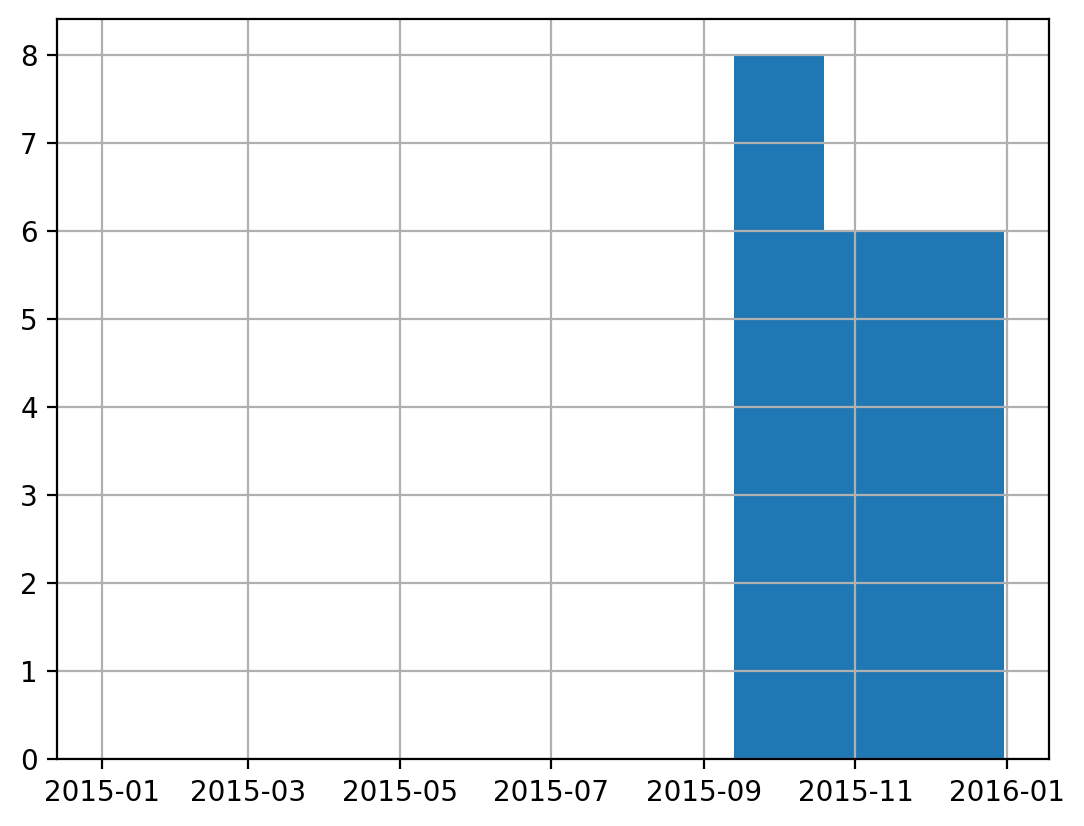

In [57]:
df.INSPECTION_DATE.hist(range=(pd.to_datetime('2015-01-01'),pd.to_datetime('2015-12-31')))

In [52]:
# Drop the 1900-01-01 inspections. These are all incorrect and we cannot fix them
df['TO_DELETE'] |= (df['INSPECTION_DATE'] == '1900-01-01')

In [53]:
# After analysis, it seems that we have minimal number of inspections before 2015
df['TO_DELETE'] |=  (df['INSPECTION_DATE'] < '2015-01-01')

In [54]:
sum(df['TO_DELETE'])

67114

### ACTION

In [58]:
sum(df.ACTION.isnull())

2346

In [65]:
df["ACTION"].value_counts()

ACTION
Violations found           216796
Establishment closed         8249
Establishment re-opened      1889
No violations                1239
Establishment re-closed         6
Name: count, dtype: int64

In [60]:
df["ACTION"].replace(
    to_replace='Violations were cited in the following area(s).',
    value = 'Violations found',
    inplace=True
)

In [61]:
df["ACTION"].replace(
    to_replace='No violations were recorded at the time of this inspection.',
    value = 'No violations',
    inplace=True
)

In [62]:
df["ACTION"].replace(
    to_replace='Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',
    value = 'Establishment closed',
    inplace=True
)

In [63]:
df["ACTION"].replace(
    to_replace='Establishment re-opened by DOHMH.',
    value = 'Establishment re-opened',
    inplace=True
)

In [64]:
df["ACTION"].replace(
    to_replace='Establishment re-closed by DOHMH.',
    value = 'Establishment re-closed',
    inplace=True
)

In [66]:
df["ACTION"].value_counts()

ACTION
Violations found           216796
Establishment closed         8249
Establishment re-opened      1889
No violations                1239
Establishment re-closed         6
Name: count, dtype: int64

In [67]:
# Drop the Establishment re-opened and re-closed cases
# as the inspection scores for these can be misleading
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-closed')
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-opened')
df['TO_DELETE'] |=  df.ACTION.isnull()

In [68]:
sum(df['TO_DELETE'])

67114

### SCORE

In [69]:
df["SCORE"] = pd.to_numeric(df["SCORE"])

In [70]:
df.SCORE.describe()

count    219459.000000
mean         23.287502
std          17.706682
min           0.000000
25%          11.000000
50%          19.000000
75%          31.000000
max         168.000000
Name: SCORE, dtype: float64

In [71]:
len(df)

230525

In [72]:
len( df[ df.SCORE < 0 ] )

0

In [73]:
df['TO_DELETE'] |= (df.SCORE < 0)

In [74]:
sum(df['TO_DELETE'])

67114

In [75]:
# Drop cases reported as "no violations but with positive score"
df['TO_DELETE'] |= ((df.SCORE > 0)  & (df.ACTION == 'No violations'))

# Drop cases with zero score but with violations found
df['TO_DELETE'] |= ((df.SCORE == 0)  & (df.ACTION == 'Violations found'))

In [76]:
# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='A') & (df.SCORE>13)

df['TO_DELETE'] |=  (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) )

# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='C') & (df.SCORE<28)


In [77]:
sum(df['TO_DELETE'])

73903

### RECORD_DATE

In [78]:
df["RECORD_DATE"] = pd.to_datetime(df["RECORD_DATE"], format="%m/%d/%Y")

In [79]:
# Drop record date field, as it only contains a single value
df = df.drop( 'RECORD_DATE', axis = 'columns')

### GRADE

In [80]:
df.GRADE.value_counts()

GRADE
A    78428
B    13210
N     8407
C     7839
Z     4909
P      671
Name: count, dtype: int64

In [81]:
sum(df.GRADE.isnull())

117061

In [82]:
df.query(" GRADE == 'G' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE


In [83]:
# Seems that all the "G" correspond to "A"
df.GRADE.replace('G', 'A', inplace=True)

In [84]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
143,50136297,PATISSERIE DES AMBASSADES,Manhattan,2200,FRDRCK DGLS BLVD,NaN,7577549410,African,2024-02-02,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,0,0,NaN,NaN,NaN,NaN,1,NaN,True
170,40378827,KOSHER HUT OF BROOKLYN,Brooklyn,709,KINGS HIGHWAY,11223,7183768996,Jewish/Kosher,2022-01-07,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.606197891882,-73.96543762922,315,44,041800,3177500,3066640027,BK25,True
718,50007015,EMIR PALACE,Brooklyn,4210,18 AVENUE,11218,7184310007,Middle Eastern,2022-04-11,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.631597951149,-73.975368009801,314,40,048400,3127571,3054090036,BK41,True
1271,50054666,SHIVRAM'S BAKERY,Queens,12905,LIBERTY AVE,11419,7186412253,Caribbean,2023-05-22,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.689346082505,-73.816175681174,410,28,015801,4204017,4095660057,QN55,True
1460,41528086,MOTTSU,Manhattan,285,MOTT STREET,10012,2123438017,Japanese,2021-08-09,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.72415703468,-73.99442599334,102,01,004300,1007923,1005090027,MN24,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228666,50111489,CARRANZA PIZZA,Brooklyn,603,SUTTER AVENUE,11207,3472438573,Pizza,2021-11-04,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.669165694908,-73.896621942583,305,42,115600,3084055,3037530040,BK85,True
228793,50104228,SOUTH SLOPE RESTAURANT & BAR,Brooklyn,486,5 AVENUE,11215,9175006558,American,2021-08-31,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.667743184397,-73.987502476841,306,38,013900,3022891,3010220048,BK37,True
229163,50103384,CHOCOLATE DIP,Manhattan,101,MACDOUGAL STREET,10012,4159904154,Bakery Products/Desserts,2022-04-25,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.729547887394,-74.000876759621,102,01,006500,1008732,1005420050,MN23,True
229550,41619116,PEDRO'S MEXICAN BAR & RESTAURANT,Brooklyn,73,JAY STREET,11201,7187972851,Mexican,2022-05-27,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.702516637482,-73.986673629017,302,33,002100,3000091,3000410001,BK38,True


In [85]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ").ACTION.value_counts()

ACTION
Establishment re-opened    671
Name: count, dtype: int64

In [86]:
# P assigned to 'Reopening Inspection' inspection types
df.query(" GRADE == 'P' ").INSPECTION_TYPE.value_counts()

INSPECTION_TYPE
Cycle Inspection / Reopening Inspection            487
Pre-permit (Operational) / Reopening Inspection    184
Name: count, dtype: int64

In [ ]:
# df.query(" GRADE == 'Z' ").SCORE.hist(bins=100)

In [87]:
# TODO: Figure out what Z, and Not Yet Graded means in GRADE
# Until then, we just replace these values with NULL, keeping only the A, B, C grades

#
df.GRADE.value_counts()

GRADE
A    78428
B    13210
N     8407
C     7839
Z     4909
P      671
Name: count, dtype: int64

In [88]:
df['TO_DELETE'] |=  (df.GRADE=='Z')
df['TO_DELETE'] |=  (df.GRADE=='P')
df['TO_DELETE'] |=  (df.GRADE=='N') # Not Yet Graded
df['TO_DELETE'] |=  (df.GRADE=='Not Yet Graded')

### GRADE_DATE

In [89]:
df["GRADE_DATE"] = pd.to_datetime(df["GRADE_DATE"], format="%m/%d/%Y")


In [90]:
# Grade date and inspection date should be the same.
assert np.abs((df.GRADE_DATE - df.INSPECTION_DATE).dropna()).sum().days == 0

In [91]:
# Check that is there is a grade date, a grade is also assigned
assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() )  == 0

In [92]:
# We do not need GRADE DATE if we have INSPECTION DATE
df = df.drop("GRADE_DATE", axis='columns')

### VIOLATION_CODE and VIOLATION_DESCRIPTION

In [93]:
df.VIOLATION_CODE.isnull().sum()

3546

In [94]:
# All the cases where violation code is NULL should be either cases that we delete
# or a "No violations" case
check = df[df.VIOLATION_CODE.isnull() & ~df.TO_DELETE & (df.ACTION!='No violations')]

assert( len(check) == 0 )


In [95]:
df.VIOLATION_DESCRIPTION.isnull().sum()

3546

In [96]:
# Checks that all VIOLATION_CODE has unique VIOLATION_DESCRIPTION
df[['VIOLATION_CODE','VIOLATION_DESCRIPTION']].drop_duplicates().pivot_table(
    index='VIOLATION_CODE',
    values='VIOLATION_DESCRIPTION',
    aggfunc=pd.Series.nunique
).sort_values('VIOLATION_DESCRIPTION', ascending=False).head(20)

,VIOLATION_DESCRIPTION
VIOLATION_CODE,
06C,4
05C,4
06A,4
02A,3
10H,3
05D,3
05B,3
04N,3
08C,3


In [97]:
df['TO_DELETE'] |=  (df.VIOLATION_DESCRIPTION == 'Caloric content not posted on menus, menu boards or food tags, in a food service establishment that is 1 of 15 or more outlets operating the same type of business nationally under common ownership or control, or as a franchise or doing business under the same name, for each menu item that is served in portions, the size and content of which are standardized.')

In [98]:
# In the dataset we have a NULL violation, when there is no violation
# To make this more explicit, we replace NULL with 000
# df.VIOLATION_CODE.fillna('000', inplace=True)

In [99]:
df.VIOLATION_CODE.isnull().sum()

3546

In [ ]:
## LATITUDE and LONGITUDE

In [100]:
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'])
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'])

### MISC analysis

In [101]:
# Find the unique values in each column
#
# df.describe(include = [np.object, 'category']).T['unique']
unique = df.describe(include = 'all').T['unique'].sort_values()

for column in unique.index:
    if unique[column] < 200:
        print(df[column].value_counts())
        print("=====")

TO_DELETE
False    151238
True      79287
Name: count, dtype: int64
=====
CRITICAL_FLAG
Critical          124532
Not Critical      101049
Not Applicable      4944
Name: count, dtype: int64
=====
ACTION
Violations found           216796
Establishment closed         8249
Establishment re-opened      1889
No violations                1239
Establishment re-closed         6
Name: count, dtype: int64
=====
BORO
Manhattan        84994
Brooklyn         62003
Queens           54580
Bronx            20517
Staten Island     8415
0                   16
Name: count, dtype: int64
=====
GRADE
A    78428
B    13210
N     8407
C     7839
Z     4909
P      671
Name: count, dtype: int64
=====
INSPECTION_TYPE
Initial Inspection                                             122828
Re-inspection                                                   43153
Pre-permit (Operational) / Initial Inspection                   34690
Pre-permit (Operational) / Re-inspection                        10078
Administrative Miscel

In [102]:
df.dtypes

CAMIS                            object
DBA                              object
BORO                             object
BUILDING                         object
STREET                           object
ZIPCODE                          object
PHONE                            object
CUISINE_DESCRIPTION              object
INSPECTION_DATE          datetime64[ns]
ACTION                           object
VIOLATION_CODE                   object
VIOLATION_DESCRIPTION            object
CRITICAL_FLAG                    object
SCORE                           float64
GRADE                            object
INSPECTION_TYPE                  object
LATITUDE                        float64
LONGITUDE                       float64
COMMUNITY_BOARD                  object
COUNCIL_DISTRICT                 object
CENSUS_TRACT                     object
BIN                              object
BBL                              object
NTA                              object
TO_DELETE                          bool


## Deleting Entries

In this section, we use the results of the analysis above, and delete (additional) entries that will not be useful in our analysis. (Note that it is important to document this, as others may want to go back to the original source, if the entries that we leave are not sufficient.)

In [103]:
len(df)

230525

In [104]:
assert len(df) == initial_size

In [105]:
df = df[ df.TO_DELETE == False].copy()

In [106]:
len(df)

151238

In [107]:
df[df.VIOLATION_CODE.isnull()].VIOLATION_DESCRIPTION

25        NaN
91        NaN
125       NaN
245       NaN
254       NaN
         ... 
226952    NaN
227061    NaN
227840    NaN
227891    NaN
230084    NaN
Name: VIOLATION_DESCRIPTION, Length: 270, dtype: object

## Additional Data Quality Checks

In [108]:


assert sum(df.INSPECTION_TYPE.isnull()) == 0

assert len(set(df.INSPECTION_TYPE.values)) == 2

df["INSPECTION_TYPE"] =  pd.Categorical(df["INSPECTION_TYPE"], ordered=False)

In [109]:
# Check that no borough entries are empty
assert sum(df.BORO.isnull()) == 0

df["BORO"] =  pd.Categorical(df["BORO"], ordered=False)

In [110]:
# Check that no street numbers are empty
assert sum(df.BUILDING.isnull()) == 0

In [111]:
assert sum(df.STREET.isnull()) == 0

In [112]:

assert sum(df.CUISINE_DESCRIPTION.isnull()) == 0

df["CUISINE_DESCRIPTION"] =  pd.Categorical(df["CUISINE_DESCRIPTION"], ordered=False)

In [113]:
# We only keep three different actions
assert len(set(df.ACTION.values)) == 3

# No action is empty
assert sum(df.ACTION.isnull()) == 0

df["ACTION"] =  pd.Categorical(df["ACTION"], ordered=False)

In [114]:
# The below drops any grade values other than A, B, C, and converts the remaining entries to null
df["GRADE"] =  pd.Categorical(df["GRADE"], categories = ['A', 'B', 'C'], ordered=True)

# https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf
# 0-13 get an A
assert sum( (df.GRADE=='A') & (df.SCORE>13)) == 0

# 14-27 get a B
assert sum( (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) ) ) == 0

# 28- get a C
assert sum( (df.GRADE=='C') & (df.SCORE<28) ) == 0

# TODO: In principle, a NULL grade is only when the score is above 14, and it was an initial inspection

In [ ]:
# Check that is there is a grade date, a grade is also assigned
# assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() ) == 0

In [115]:
df["VIOLATION_CODE"] =  pd.Categorical(df["VIOLATION_CODE"], ordered=False)
df["CRITICAL_FLAG"] =  pd.Categorical(df["CRITICAL_FLAG"], ordered=False)


In [116]:
df [ df.VIOLATION_CODE.isnull() ].VIOLATION_DESCRIPTION

25        NaN
91        NaN
125       NaN
245       NaN
254       NaN
         ... 
226952    NaN
227061    NaN
227840    NaN
227891    NaN
230084    NaN
Name: VIOLATION_DESCRIPTION, Length: 270, dtype: object

## Normalization

### Violation Codes

In [117]:
# Recreating the table at https://www1.nyc.gov/assets/doh/downloads/pdf/rii/ri-violation-penalty.pdf

violation_codes = df [ ['VIOLATION_CODE', 'VIOLATION_DESCRIPTION', 'CRITICAL_FLAG'] ].drop_duplicates()
violation_codes = violation_codes.rename( {
    'VIOLATION_DESCRIPTION' : 'DESCRIPTION',
    'CRITICAL_FLAG' : 'CRITICAL'
},  axis = 'columns').sort_values('VIOLATION_CODE').dropna().set_index('VIOLATION_CODE')
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
02B,Hot food item not held at or above 140º F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [119]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
02B,Hot food item not held at or above 140º F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [118]:
# Drop the description and critical part from the main dataframe
df = df.drop(['VIOLATION_DESCRIPTION' ,  'CRITICAL_FLAG'], axis='columns')

In [ ]:
df

### Restaurants

In [120]:
df.columns.values

array(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESCRIPTION', 'INSPECTION_DATE', 'ACTION',
       'VIOLATION_CODE', 'SCORE', 'GRADE', 'INSPECTION_TYPE', 'LATITUDE',
       'LONGITUDE', 'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BIN', 'BBL', 'NTA', 'TO_DELETE'], dtype=object)

In [121]:
columns = ['CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'BORO', 'PHONE',
           'CUISINE_DESCRIPTION', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT', 'BIN',
       'BBL', 'NTA']
restaurants =  df [ columns ].drop_duplicates()

In [122]:
# Check that we have the same attributes for a given CAMIS
# and the we do not have duplicate CAMIS values
assert len(restaurants) == len(set(restaurants.CAMIS.values))

In [123]:
restaurants.head(5)

,CAMIS,DBA,BUILDING,STREET,ZIPCODE,BORO,PHONE,CUISINE_DESCRIPTION,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA
20,50086391,FIX-U-PLATE,1139/1141,CLARKSON AVE,11212,Brooklyn,9292343888,Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,41665255,MCHALE'S BAR & GRILL,251,WEST 51 STREET,10019,Manhattan,2129575138,Irish,40.762470,-73.984586,105,03,013100,1024815,1010230005,MN17
25,50103070,SUSHI YOU GARDEN,21505,73RD AVE,11364,Queens,7182811188,Japanese,40.740584,-73.759067,411,23,136700,4163155,4076380001,QN42
28,50091303,CAFE PARIS,4424,16 AVENUE,11204,Brooklyn,7188532353,Jewish/Kosher,40.633658,-73.982793,312,44,023200,3128325,3054310046,BK88
29,50065361,NAPOLI'S BISTRO,2851,42ND ST,11103,Queens,3475310202,Italian,40.764431,-73.912328,401,22,014700,4012076,4006980048,QN70


In [124]:
restaurants.PHONE.value_counts().head(20)

PHONE
2124656273    43
9176186310    30
9172843260    29
2126159700    23
2125867610    18
7182153308    14
2124656302    14
2122441111    12
9178863304    12
2123959280    10
3477017760    10
__________    10
6143187413    10
2125825472     9
9177437388     9
7186566210     9
2125325003     8
9177965620     8
2126191222     7
9175103862     7
Name: count, dtype: int64

In [ ]:
# __ = restaurants.PHONE.value_counts().head(10).index.values[7]

In [ ]:
# restaurants.PHONE.replace(to_replace=__, value=np.nan, inplace=True)

In [ ]:
# Citi Field concessions
# restaurants.query("PHONE == '7185958100'").head(5)

In [ ]:
# Madison Square Garden concession stands
# restaurants.query("PHONE == '2124656273'").head(5)

In [ ]:
# restaurants.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', alpha=0.2, s=1, figsize=(15,15))

In [125]:
df = df.drop (columns[1:], axis='columns')

In [126]:
df

,CAMIS,INSPECTION_DATE,ACTION,VIOLATION_CODE,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
20,50086391,2023-04-05,Violations found,02B,44.0,NaN,Initial Inspection,False
21,41665255,2022-01-14,Violations found,02B,33.0,NaN,Initial Inspection,False
25,50103070,2023-03-23,No violations,NaN,0.0,NaN,Initial Inspection,False
28,50091303,2020-02-06,Violations found,09B,13.0,A,Initial Inspection,False
29,50065361,2022-01-06,Violations found,09C,13.0,A,Initial Inspection,False
...,...,...,...,...,...,...,...,...
230520,50040555,2022-01-20,Violations found,10F,4.0,A,Initial Inspection,False
230521,40396159,2024-02-01,Violations found,09C,12.0,A,Initial Inspection,False
230522,41585425,2024-04-03,Violations found,06C,31.0,NaN,Initial Inspection,False
230523,50075227,2022-11-15,Violations found,04H,38.0,NaN,Initial Inspection,False


### Inspections

In [127]:
# Each inspection has multiple violations. We want to keep just the inspections for now
inspection = df.drop('VIOLATION_CODE', axis='columns').drop_duplicates().sort_values(['INSPECTION_DATE', 'CAMIS'])

In [ ]:
inspection

In [128]:
# We create an ID for each inspection here
inspection = inspection.reset_index().drop('index', axis='columns').reset_index().rename({'index': 'INSPECTION_ID'}, axis='columns')

In [129]:
inspection.ACTION.value_counts()

ACTION
Violations found        46581
Establishment closed      783
No violations             276
Name: count, dtype: int64

In [130]:
# Ensure that the inspection table contains
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
pvt [ pvt.INSPECTION_ID > 1 ]

# assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0

,,INSPECTION_ID
INSPECTION_DATE,CAMIS,
2017-11-04,40911114,2


In [ ]:
# df[ (df.CAMIS =='41007054') & (df.INSPECTION_DATE == '2017-03-03')  ].sort_values('VIOLATION_CODE')

In [ ]:
# to_drop = inspection.query(" CAMIS =='50051092' and  INSPECTION_DATE == '2019-09-11' ").index.values[1]
# inspection = inspection.drop(to_drop, axis='index')

In [131]:
to_drop = inspection.query(" CAMIS =='40911114' and  INSPECTION_DATE == '2017-11-04' ").index.values[1]

inspection = inspection.drop(to_drop, axis='index')

In [132]:
inspection.drop('TO_DELETE', axis='columns', inplace=True)

In [133]:
# Ensure that the inspection table contains
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0

In [134]:
inspection.INSPECTION_TYPE.value_counts()

INSPECTION_TYPE
Initial Inspection    35307
Re-inspection         12332
Name: count, dtype: int64

In [135]:
inspection_stats = inspection.pivot_table(
    index = 'CAMIS',
    aggfunc = ['min', 'max', 'count'],
    values = 'INSPECTION_DATE'
)

<Axes: xlabel='INSPECTION_DATE'>

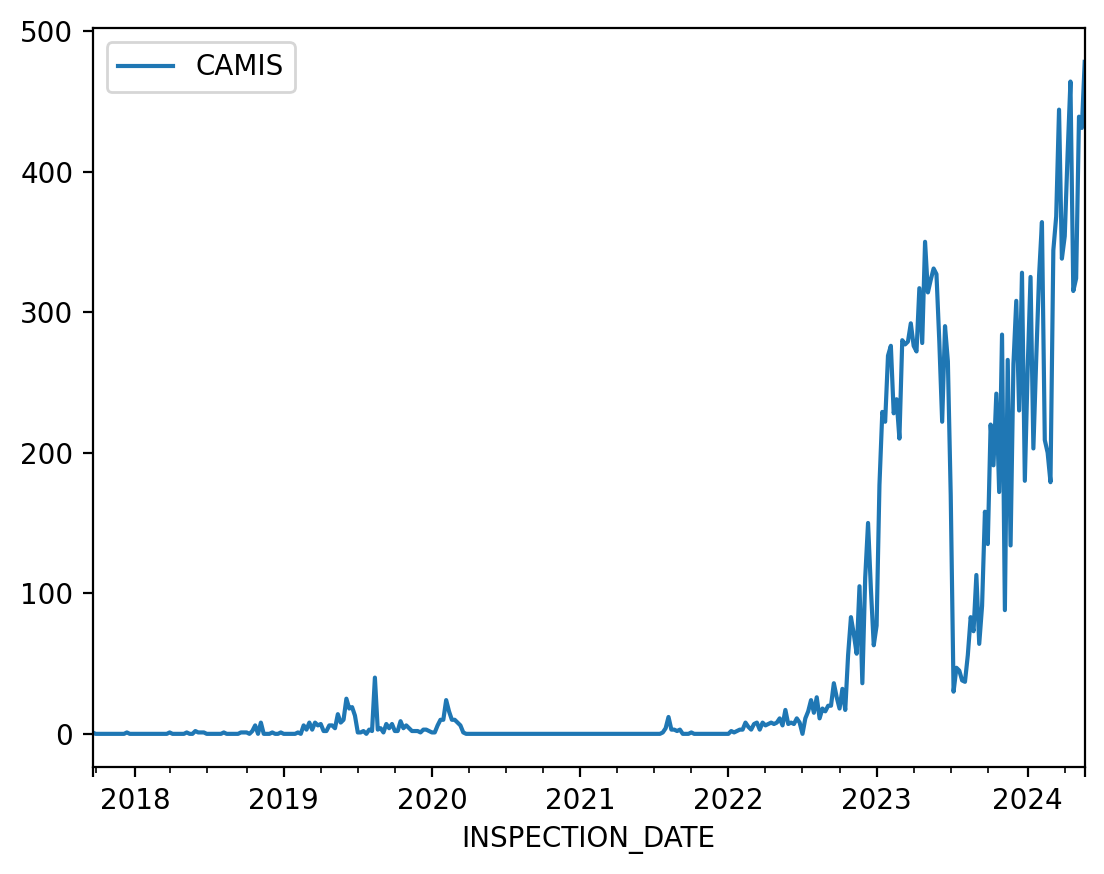

In [136]:
# Distribution of last inspection across all restaurants
inspection_stats['max'].sort_values('INSPECTION_DATE').reset_index().pivot_table(
    index='INSPECTION_DATE',
    aggfunc='count'
).resample('1W').sum().plot()

In [ ]:
# Longevity
# (inspection_stats['max'] - inspection_stats['min'])['INSPECTION DATE'].sort_values()

<Axes: xlabel='INSPECTION_DATE'>

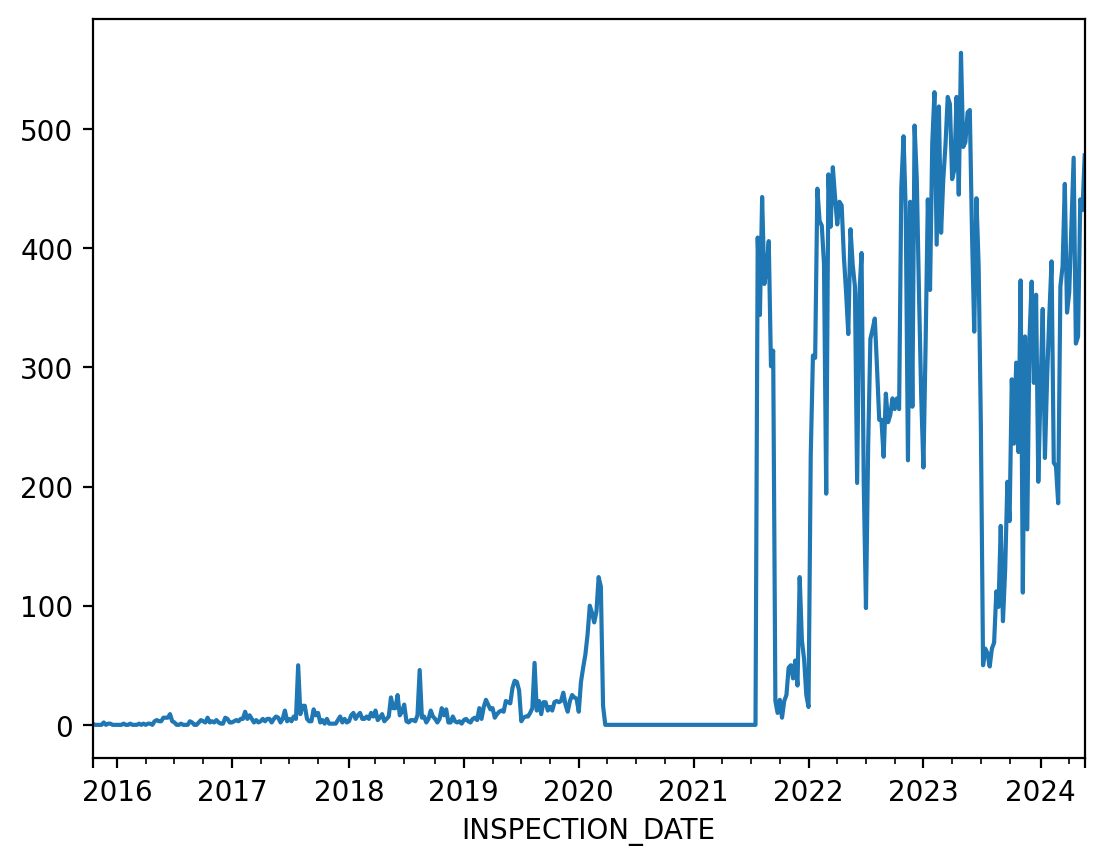

In [137]:
# Distribution of all inspections
inspection['INSPECTION_DATE'].value_counts().sort_index().resample('1W').sum().plot()

In [ ]:
len(df)

In [138]:
violations = pd.merge(
    inspection,
    df[ ['CAMIS', 'INSPECTION_DATE', 'VIOLATION_CODE' ] ],
    on= ['CAMIS', 'INSPECTION_DATE'],
    how = 'inner'
)
violations = violations[ ['INSPECTION_ID', 'VIOLATION_CODE'] ].drop_duplicates()
len(violations)

151234

In [139]:
print(f"Violations: {len(violations)}")
print(f"Inspections: {len(inspection)}")
print(f"Restaurants: {len(restaurants)}")
print(f"Violation Codes: {len(violation_codes)}")

Violations: 151234
Inspections: 47639
Restaurants: 19742
Violation Codes: 149


## Storing in MySQL


In [140]:
!sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.6 MB/s eta 0:00:00


In [141]:
import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'root',
    password = mysql_pass,
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

In [153]:
# Query to create a database
db_name = 'doh_restaurants'

sql = f"DROP DATABASE IF EXISTS {db_name}"
with engine.connect() as connection:
  connection.execute(text(sql))

# Create a database
sql = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8mb4'"
with engine.connect() as connection:
  connection.execute(text(sql))

# And lets switch to the database
sql = f"USE {db_name}"
with engine.connect() as connection:
  connection.execute(text(sql))

In [154]:
create_table_sql = '''
CREATE TABLE restaurants (
    CAMIS                      char(8),
    DBA varchar(100),
    BUILDING varchar(10),
    STREET varchar(40),
    ZIPCODE char(5),
    BORO ENUM('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island')  ,
    PHONE char(10),
    CUISINE_DESCRIPTION    varchar(30),
LATITUDE                float,
LONGITUDE               float,
COMMUNITY_BOARD          char(3),
COUNCIL_DISTRICT         char(2),
CENSUS_TRACT             char(6),
BIN                      char(7),
BBL                      char(10),
NTA                      char(4),
PRIMARY KEY(CAMIS)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))


create_table_sql = '''
CREATE TABLE inspections (
    INSPECTION_ID               char(8),
    CAMIS                      char(8),
    INSPECTION_DATE    datetime,
    ACTION                   ENUM('Violations found','Establishment closed','No violations'),
    SCORE                     smallint,
    GRADE                    char(1),
    INSPECTION_TYPE          ENUM('Initial Inspection','Re-inspection'),
    FOREIGN KEY(CAMIS) REFERENCES restaurants(CAMIS),
    PRIMARY KEY(INSPECTION_ID)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))

create_table_sql = '''
CREATE TABLE violation_codes (
  VIOLATION_CODE     char(5),
  DESCRIPTION varchar(1000),
  CRITICAL ENUM('Critical', 'Not Applicable', 'Not Critical'),
  PRIMARY KEY(VIOLATION_CODE)

) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))


create_table_sql = '''
CREATE TABLE violations (
  INSPECTION_ID         char(8),
  VIOLATION_CODE     char(5),
  FOREIGN KEY(INSPECTION_ID) REFERENCES inspections(INSPECTION_ID)
  -- FOREIGN KEY(VIOLATION_CODE) REFERENCES violation_codes(VIOLATION_CODE)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))

In [144]:
violation_codes.reset_index().VIOLATION_CODE.str.len().max()

5

In [145]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
02B,Hot food item not held at or above 140º F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [146]:
violation_codes = violation_codes.groupby('VIOLATION_CODE').first()

In [155]:
violation_codes.reset_index().to_sql(
        name = 'violation_codes',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

72

In [151]:
restaurants.DBA.str.len().max()

100

In [156]:
restaurants.to_sql(
        name = 'restaurants',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

19742

In [157]:
inspection.to_sql(
        name = 'inspections',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

47639

In [158]:
violations.to_sql(
        name = 'violations',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

151234

In [159]:
sql = '''
GRANT SELECT ON doh_restaurants.* TO 'student'@'%'
'''
with engine.connect() as connection:
  connection.execute(text(sql))

In [160]:


sql = '''
CREATE VIEW restaurant_inspection_latest AS
	WITH latest_inspection AS (
		SELECT CAMIS, MAX(INSPECTION_DATE) AS INSPECTION_DATE FROM inspections
		GROUP BY CAMIS
	)
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, I.INSPECTION_DATE, I.INSPECTION_ID, I.INSPECTION_TYPE, V.VIOLATION_CODE, I.SCORE, I.GRADE
		FROM restaurants R
			JOIN latest_inspection L ON R.CAMIS = L.CAMIS
			JOIN inspections I ON I.CAMIS = L.CAMIS AND L.INSPECTION_DATE = I.INSPECTION_DATE
			JOIN violations V ON I.INSPECTION_ID = V.INSPECTION_ID
      '''

with engine.connect() as connection:
  connection.execute(text(sql))